<a href="https://colab.research.google.com/github/suchitra2020180/RS_GIS_Python/blob/main/Data_visualisation_Python_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Day 8: XArray -Basics, visualisation

Introduction to XArray
XArray Basics
Visualizing Monthly Median Composites with XArray


##Overview
XArray is the package used to work with raster datasets and gridded datasets for weather and climate.

In python to work with raster data we generally use rasterio, rasterio is used to read differnt formats of raster data, but the API of rasterio is not suitable for time series data.
In pandas it is very easy to work with filtering and manipulation of data, but it is difficult with rasterio as it deals with files.

Xarray is an evolution of rasterio and is inspired by libraries like pandas to work with raster datasets.
It supports vectorised operations on arrys resulting in magnitudes of faster processing over other Python/R packages.[benchmark](https://kadyb.github.io/raster-benchmark/report.html).
It supports multiprocessing in cloud.

It is particularly suited for working with multi-dimensional time-series raster datasets. It also integrates tightly with dask that allows one to scale raster data processing using parallel computing. XArray provides [Plotting Functions](https://docs.xarray.dev/en/stable/user-guide/plotting.html) based on Matplotlib.
Fast evolving ecosystem around spatial extensions (rioxarray, xarray-spatial, xy-scipy etc.)



In this section, we will learn about XArray basics and learn how to work with a time-series of Sentinel-2 satellite imagery to create and visualize a median composite image.


##Basic Terminology:
Variables: This is similar to a band in a raster dataset. Each variable contains an array of values.(Ex: satellite has 3 bands-blue,green and red bands, so 3 variables; for climate data-precipitaion and temperature are variables)
Dimensions: This is similar to number of array axes. A grid of pixels (lat and lon) at multiple time intervals time with multiple variables is a 4D dataset (lat,long,time and bands).

A typical dataset has 4 dimensions- X,Y, time, bands in each timestamp.
Coordinates: These are the labels for values in each dimension. We have labels for lat, lon and time.
Attributes: This is the metadata associated with the dataset.

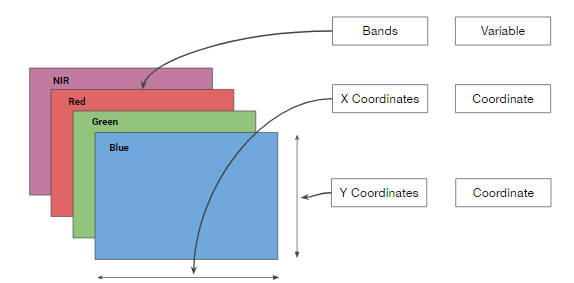

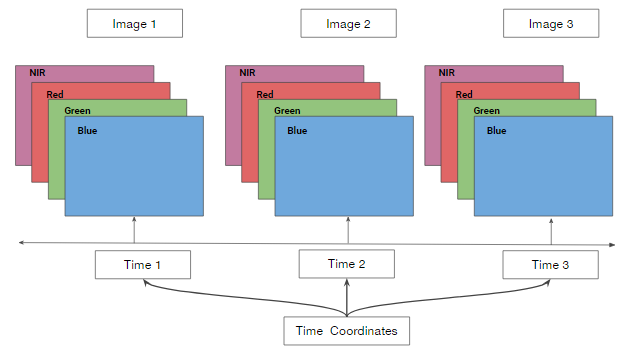

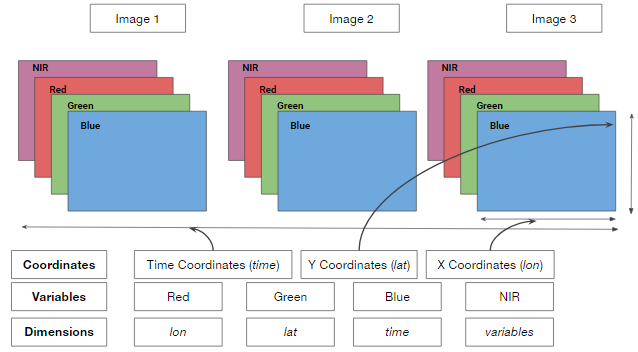


Let's say we have multiple images of a same area over different times. We need blue band from image 2. Then we need to say we need a variable (blue) from time coordinate (time 2).
In rasterio we will all images seperately and work seperately.But in xarray all the images are read in a single variable. This makes all operations easy.



##Xarray Basics
In this section, we will learn about XArray basics and learn how to work with a time-series of Sentinel-2 satellite imagery to create and visualize a median composite image.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install pystac-client odc-stac rioxarray
    !pip install --upgrade dask

In [ ]:
!pip install pystac-client odc-stac rioxarray
!pip install --upgrade dask

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.4 MB/s eta 0:00:00
  Attempting uninstall: dask
    Found existing installation: dask 2024.8.2
    Uninstalling dask-2024.8.2:
      Successfully uninstalled dask-2024.8.2


==>The **pystac-client** module is a Python library used for interacting with SpatioTemporal Asset Catalogs (STAC) via STAC APIs. STAC is a standard format for representing geospatial data, which makes it easier to search, discover, and access satellite imagery and other spatial datasets.

The pystac-client library provides a convenient way to search and retrieve metadata about geospatial assets using STAC APIs. It can be used to query STAC-compliant datasets from various data providers, filter search results, and access geospatial data efficiently.


==>The **odc_stack** module is part of the Open Data Cube [(ODC)](https://www.opendatacube.org/) ecosystem, which is an open-source geospatial data management platform. Open Data Cube is widely used for handling and analyzing large-scale Earth observation data from satellites.

In [ ]:
import os
import xarray as xr
import rioxarray as rxr
import pystac_client
from odc.stac import stac_load
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

import os
main_path="/content/drive/MyDrive/Jobs_Projects_Doc/Spatial_Analysis_Python"
data_folder="data"
output_folder="output"

data_folder_path=os.path.join(main_path,data_folder)
output_folder_path=os.path.join(main_path,output_folder)

if not os.path.exists(data_folder_path):
  os.mkdir(data_folder_path)

if not os.path.exists(output_folder_path):
  os.mkdir(output_folder_path)

##Get Satellite Imagery using STAC API

We define a location and time of interest to get some satellite imagery.

In [ ]:
latitude = 27.163
longitude = 82.608
year = 2023

Let’s use [Element8](https://www.element84.com/earth-search/) search endpoint to look for items from the sentinel-2-l2a collection on AWS and access it using pystac_client


In [ ]:
#Define a bounding box
km2deg=1.0/111
x,y=(longitude,latitude)
r=1*km2deg
#Create bounding box for that point
bbox=(x-r,y-r,x+r,y+r)

#Access satellite data through Amazon STAC API using pystac_client module for the gievn lat,long.
aws_catalog = pystac_client.Client.open('https://earth-search.aws.element84.com/v1')
search = aws_catalog.search(
    collections=['sentinel-2-c1-l2a'],
    bbox=bbox,
    datetime=f'{year}',
    query={'eo:cloud_cover':{'lt':30}},
)

items=search.item_collection()
print('AWS Catalog:',aws_catalog)
print('Search:',search)
print('Items:',items)

AWS Catalog: <Client id=earth-search-aws>
Search: <pystac_client.item_search.ItemSearch object at 0x7f1e4eefa7a0>
Items: <pystac.item_collection.ItemCollection object at 0x7f1e4eefb010>


## After accessing data from STAC API, the items should be read using **stac_load**
Load the matching images as a XArray Dataset.

In [ ]:
ds = stac_load(
    items,
    bands=['red','green','blue','nir'],
    resolution=10,
    bbox=bbox,
    chunks={}, #for Dask
    groupby='solar_day',
    )

ds

<xarray.Dataset> Size: 21MB
Dimensions:      (y: 202, x: 182, time: 70)
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * time         (time) datetime64[ns] 560B 2023-01-13T05:21:06.880000 ... 20...
Data variables:
    red          (time, y, x) uint16 5MB dask.array<chunksize=(1, 202, 182), meta=np.ndarray>
    green        (time, y, x) uint16 5MB dask.array<chunksize=(1, 202, 182), meta=np.ndarray>
    blue         (time, y, x) uint16 5MB dask.array<chunksize=(1, 202, 182), meta=np.ndarray>
    nir          (time, y, x) uint16 5MB dask.array<chunksize=(1, 202, 182), meta=np.ndarray>

In [ ]:
ds.compute()

<xarray.Dataset> Size: 21MB
Dimensions:      (y: 202, x: 182, time: 70)
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * time         (time) datetime64[ns] 560B 2023-01-13T05:21:06.880000 ... 20...
Data variables:
    red          (time, y, x) uint16 5MB 7592 7548 7388 7236 ... 2038 2198 2240
    green        (time, y, x) uint16 5MB 7308 7260 7188 7064 ... 2204 2192 2188
    blue         (time, y, x) uint16 5MB 7332 7152 7112 7036 ... 1947 2010 2040
    nir          (time, y, x) uint16 5MB 8076 7996 7840 7708 ... 3978 3708 3352

In [ ]:
%%time

UsageError: %%time is a cell magic, but the cell body is empty. Did you mean the line magic %time (single %)?


In [ ]:
%%time
ds.compute()

CPU times: user 12.6 s, sys: 25.1 s, total: 37.6 s
Wall time: 1min 18s


<xarray.Dataset> Size: 21MB
Dimensions:      (y: 202, x: 182, time: 70)
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * time         (time) datetime64[ns] 560B 2023-01-13T05:21:06.880000 ... 20...
Data variables:
    red          (time, y, x) uint16 5MB 7592 7548 7388 7236 ... 2038 2198 2240
    green        (time, y, x) uint16 5MB 7308 7260 7188 7064 ... 2204 2192 2188
    blue         (time, y, x) uint16 5MB 7332 7152 7112 7036 ... 1947 2010 2040
    nir          (time, y, x) uint16 5MB 8076 7996 7840 7708 ... 3978 3708 3352

In [ ]:
%time

CPU times: user 3 µs, sys: 3 µs, total: 6 µs
Wall time: 10.3 µs


## XArray Terminology

We now have a `xarray.Dataset` object. Let's understand what is contained in a Dataset.

* *Variables*: This is similar to a band in a raster dataset. Each variable contains an array of values.
* *Dimensions*: This is similar to number of array axes.
* *Coordinates*: These are the labels for values in each dimension.
* *Attributes*: This is the metadata associated with the dataset.

<img src='https://courses.spatialthoughts.com/images/python_dataviz/xarray_terminology.png' width=800/>

A Dataset consists of one or more **xarray.DataArray object**. This is the main object that consists of a single variable with dimension names, coordinates and attributes. You can access each variable using dataset.variable_name syntax.

In [ ]:
da=ds.red
da

<xarray.DataArray 'red' (time: 70, y: 202, x: 182)> Size: 5MB
dask.array<red, shape=(70, 202, 182), dtype=uint16, chunksize=(1, 202, 182), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * time         (time) datetime64[ns] 560B 2023-01-13T05:21:06.880000 ... 20...
Attributes:
    nodata:   0

##Selecting Data
XArray provides a very powerful way to select subsets of data, using similar framework as Pandas. Similar to Panda's loc and iloc methods, XArray provides sel and isel methods. Since DataArray dimensions have names, these methods allow you to specify which dimension to query.

Let's select the temperature anomany values for the last time step. Since we know the index (-1) of the datam we can use isel method.

In [ ]:
da.isel(time=-1)

<xarray.DataArray 'red' (y: 202, x: 182)> Size: 74kB
dask.array<getitem, shape=(202, 182), dtype=uint16, chunksize=(202, 182), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
    time         datetime64[ns] 8B 2023-12-26T05:11:10.219000
Attributes:
    nodata:   0

You can call .values on a DataArray to get an array of the values.

In [ ]:
da.isel(time=-1).values

array([[   0,    0,    0, ..., 1821, 1762, 1830],
       [   0,    0,    0, ..., 1818, 1750, 1814],
       [   0,    0,    0, ..., 1776, 1816, 1832],
       ...,
       [2078, 2092, 2058, ..., 1899, 2152, 2302],
       [2080, 2084, 2090, ..., 1936, 2188, 2290],
       [1970, 2030, 2034, ..., 2038, 2198, 2240]], dtype=uint16)

In [ ]:
da.isel(time=-1, x=-1, y=-1)

<xarray.DataArray 'red' ()> Size: 2B
dask.array<getitem, shape=(), dtype=uint16, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    y            float64 8B 3.005e+06
    x            float64 8B 6.602e+05
    spatial_ref  int32 4B 32644
    time         datetime64[ns] 8B 2023-12-26T05:11:10.219000
Attributes:
    nodata:   0

You can query for a values at using multiple dimensions.

In [ ]:
da.isel(time=-1, x=-1, y=-1).values

array(2240, dtype=uint16)

We can also specify a value to query using the sel() method.

Let's see what are the values of time variable.

In [ ]:
da.time

<xarray.DataArray 'time' (time: 70)> Size: 560B
array(['2023-01-13T05:21:06.880000000', '2023-01-18T05:21:06.614000000',
       '2023-01-23T05:21:05.552000000', '2023-02-07T05:21:07.419000000',
       '2023-02-09T05:11:12.073000000', '2023-02-12T05:21:07.542000000',
       '2023-02-14T05:11:11.668000000', '2023-02-19T05:11:10.303000000',
       '2023-02-22T05:21:06.867000000', '2023-03-01T05:11:10.619000000',
       '2023-03-04T05:21:06.040000000', '2023-03-06T05:11:16.188000000',
       '2023-03-09T05:21:13.261000000', '2023-03-11T05:11:08.720000000',
       '2023-03-24T05:21:07.945000000', '2023-03-26T05:11:16.033000000',
       '2023-04-03T05:21:08.616000000', '2023-04-05T05:11:16.355000000',
       '2023-04-08T05:21:11.786000000', '2023-04-10T05:11:13.434000000',
       '2023-04-13T05:21:09.401000000', '2023-04-18T05:21:11.018000000',
       '2023-04-23T05:21:08.563000000', '2023-04-25T05:11:15.158000000',
       '2023-05-05T05:11:15.867000000', '2023-05-10T05:11:12.717000000',
       '2023-05-13T05:21:09.142000000', '2023-05-18T05:21:14.056000000',
       '2023-05-20T05:11:15.658000000', '2023-05-28T05:21:13.828000000',
       '2023-05-30T05:11:17.093000000', '2023-06-02T05:21:13.236000000',
       '2023-06-04T05:11:17.494000000', '2023-06-07T05:21:14.094000000',
       '2023-06-09T05:11:16.986000000', '2023-06-12T05:21:13.428000000',
       '2023-06-14T05:11:18.288000000', '2023-06-17T05:21:14.149000000',
       '2023-06-19T05:11:17.345000000', '2023-06-22T05:21:13.013000000',
       '2023-07-22T05:21:13.598000000', '2023-08-28T05:11:19.006000000',
       '2023-09-30T05:21:11.559000000', '2023-10-10T05:21:08.417000000',
       '2023-10-12T05:11:15.242000000', '2023-10-15T05:21:11.673000000',
       '2023-10-20T05:21:09.168000000', '2023-10-22T05:11:14.930000000',
       '2023-10-25T05:21:10.189000000', '2023-10-27T05:11:13.227000000',
       '2023-10-30T05:21:08.875000000', '2023-11-01T05:11:15.740000000',
       '2023-11-04T05:21:12.121000000', '2023-11-06T05:11:12.695000000',
       '2023-11-09T05:21:08.806000000', '2023-11-14T05:21:09.587000000',
       '2023-11-16T05:11:11.658000000', '2023-11-19T05:21:06.701000000',
       '2023-11-21T05:11:09.709000000', '2023-11-24T05:21:04.450000000',
       '2023-11-26T05:11:07.426000000', '2023-11-29T05:21:01.463000000',
       '2023-12-01T05:11:10.337000000', '2023-12-06T05:11:06.903000000',
       '2023-12-09T05:21:03.902000000', '2023-12-11T05:11:10.078000000',
       '2023-12-14T05:21:07.692000000', '2023-12-16T05:11:09.255000000',
       '2023-12-24T05:21:10.640000000', '2023-12-26T05:11:10.219000000'],
      dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 4B 32644
  * time         (time) datetime64[ns] 560B 2023-01-13T05:21:06.880000 ... 20...

In [ ]:
dates = da.time.values
dates

array(['2023-01-13T05:21:06.880000000', '2023-01-18T05:21:06.614000000',
       '2023-01-23T05:21:05.552000000', '2023-02-07T05:21:07.419000000',
       '2023-02-09T05:11:12.073000000', '2023-02-12T05:21:07.542000000',
       '2023-02-14T05:11:11.668000000', '2023-02-19T05:11:10.303000000',
       '2023-02-22T05:21:06.867000000', '2023-03-01T05:11:10.619000000',
       '2023-03-04T05:21:06.040000000', '2023-03-06T05:11:16.188000000',
       '2023-03-09T05:21:13.261000000', '2023-03-11T05:11:08.720000000',
       '2023-03-24T05:21:07.945000000', '2023-03-26T05:11:16.033000000',
       '2023-04-03T05:21:08.616000000', '2023-04-05T05:11:16.355000000',
       '2023-04-08T05:21:11.786000000', '2023-04-10T05:11:13.434000000',
       '2023-04-13T05:21:09.401000000', '2023-04-18T05:21:11.018000000',
       '2023-04-23T05:21:08.563000000', '2023-04-25T05:11:15.158000000',
       '2023-05-05T05:11:15.867000000', '2023-05-10T05:11:12.717000000',
       '2023-05-13T05:21:09.142000000', '2023-05-18

We can query using the value of a coordinate using the sel() method.

In [ ]:
da.sel(time='2023-12-16')

<xarray.DataArray 'red' (time: 1, y: 202, x: 182)> Size: 74kB
dask.array<getitem, shape=(1, 202, 182), dtype=uint16, chunksize=(1, 202, 182), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * time         (time) datetime64[ns] 8B 2023-12-16T05:11:09.255000
Attributes:
    nodata:   0

The sel() method also support nearest neighbor lookups. This is useful when you do not know the exact label of the dimension, but want to find the closest one.

Tip: You can use interp() instead of sel() to interpolate the value instead of closest lookup.

In [ ]:
da.sel(time='2023-01-01', method='nearest')

<xarray.DataArray 'red' (y: 202, x: 182)> Size: 74kB
dask.array<getitem, shape=(202, 182), dtype=uint16, chunksize=(202, 182), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
    time         datetime64[ns] 8B 2023-01-13T05:21:06.880000
Attributes:
    nodata:   0

The sel() method also allows specifying range of values using Python's built-in slice() function. The code below will select all observations during January 2023.

In [ ]:
da.sel(time=slice('2023-01-01', '2023-01-31'))

<xarray.DataArray 'red' (time: 3, y: 202, x: 182)> Size: 221kB
dask.array<getitem, shape=(3, 202, 182), dtype=uint16, chunksize=(1, 202, 182), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * time         (time) datetime64[ns] 24B 2023-01-13T05:21:06.880000 ... 202...
Attributes:
    nodata:   0

##Aggregating Data
A very-powerful feature of XArray is the ability to easily aggregate data across dimensions - making it ideal for many remote sensing analysis. Let's create a median composite from all the individual images.

We apply the .median() aggregation across the time dimension.

In [ ]:
median = ds.median(dim='time')
median

<xarray.Dataset> Size: 1MB
Dimensions:      (y: 202, x: 182)
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
Data variables:
    red          (y, x) float64 294kB dask.array<chunksize=(202, 182), meta=np.ndarray>
    green        (y, x) float64 294kB dask.array<chunksize=(202, 182), meta=np.ndarray>
    blue         (y, x) float64 294kB dask.array<chunksize=(202, 182), meta=np.ndarray>
    nir          (y, x) float64 294kB dask.array<chunksize=(202, 182), meta=np.ndarray>

##Visualizing Data
XArray provides a plot.imshow() method based on Matplotlib to plot DataArrays.

Reference : [xarray.plot.imshow](https://docs.xarray.dev/en/stable/generated/xarray.plot.imshow.html)

To visualize our Dataset, we first convert it to a DataArray using the to_array() method. All the variables will be converted to a new dimension. Since our variables are image bands, we give the name of the new dimesion as band.

In [ ]:
median_da=median.to_array('band')
median_da

<xarray.DataArray (band: 4, y: 202, x: 182)> Size: 1MB
dask.array<stack, shape=(4, 202, 182), dtype=float64, chunksize=(1, 202, 182), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * band         (band) object 32B 'red' 'green' 'blue' 'nir'

The easy way to visualize the data without the outliers is to pass the parameter robust=True. This will use the 2nd and 98th percentiles of the data to compute the color limits.

median=ds.median(dim='time')

median_da=median.to_array('band')

median_da.sel(band=['red','green','blue'])

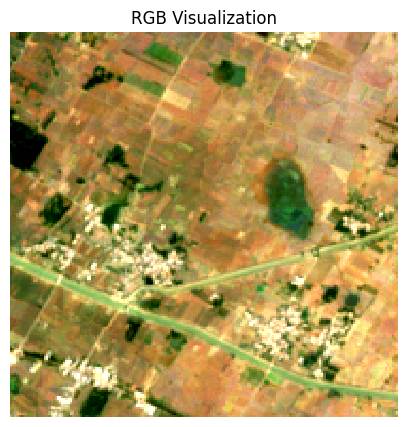

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
median_da.sel(band=['red', 'green', 'blue']).plot.imshow(
    ax=ax,
    robust=True)#If we dont knoow the min,max values then use robust=True
ax.set_title('RGB Visualization')
ax.set_axis_off()
plt.show()

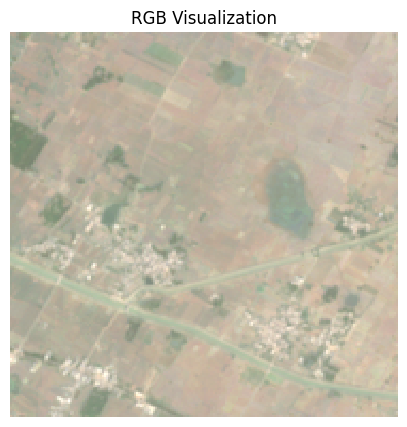

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
median_da.sel(band=['red', 'green', 'blue']).plot.imshow(
    ax=ax,
    vmin=0, vmax=3000)
ax.set_title('RGB Visualization')
ax.set_axis_off()
plt.show()

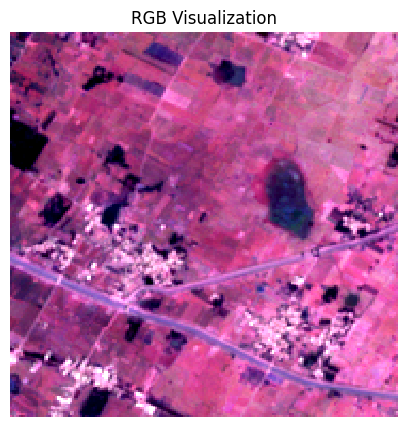

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
median_da.sel(band=['red', 'blue','green']).plot.imshow(
    ax=ax,
    robust=True)
ax.set_title('RGB Visualization')
ax.set_axis_off()
plt.show()

##Exercise
Display the median composite for the month of May.

The snippet below takes our time-series and aggregate it to a monthly median composites groupby() method.

In [ ]:
monthly_data=ds.groupby('time.month')
#Median composite of May
monthly=monthly_data.median(dim='time')
monthly

<xarray.Dataset> Size: 14MB
Dimensions:      (month: 12, y: 202, x: 182)
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * month        (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    red          (month, y, x) float64 4MB dask.array<chunksize=(1, 202, 182), meta=np.ndarray>
    green        (month, y, x) float64 4MB dask.array<chunksize=(1, 202, 182), meta=np.ndarray>
    blue         (month, y, x) float64 4MB dask.array<chunksize=(1, 202, 182), meta=np.ndarray>
    nir          (month, y, x) float64 4MB dask.array<chunksize=(1, 202, 182), meta=np.ndarray>

You now have a new dimension named month. Start your exercise by first converting the Dataset to a DataArray. Then extract the data for the chosen month using sel() method and plot it.

In [ ]:
month_da=monthly.to_array('band')
month_da

<xarray.DataArray (band: 4, month: 12, y: 202, x: 182)> Size: 14MB
dask.array<stack, shape=(4, 12, 202, 182), dtype=float64, chunksize=(1, 1, 202, 182), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * month        (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * band         (band) object 32B 'red' 'green' 'blue' 'nir'

##Visualising image for the month of May

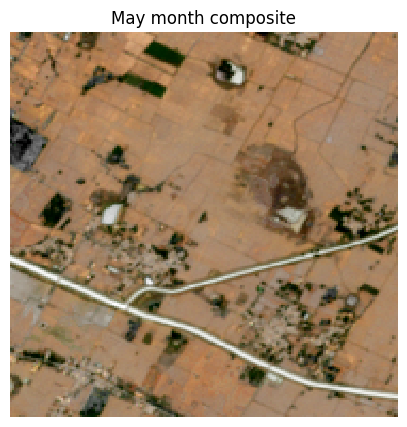

In [ ]:
fig,ax=plt.subplots(1,1)
fig.set_size_inches(5,5)
may_composite=month_da.sel(month=5)
may_composite.plot.imshow(ax=ax,robust=True)
ax.set_title('May month composite')
ax.set_axis_off()
plt.show()

##Visualizing Monthly Composites
This notebook shows how to aggregate a time-series of satellite imagery to monthly median composites and visualize them in a grid.

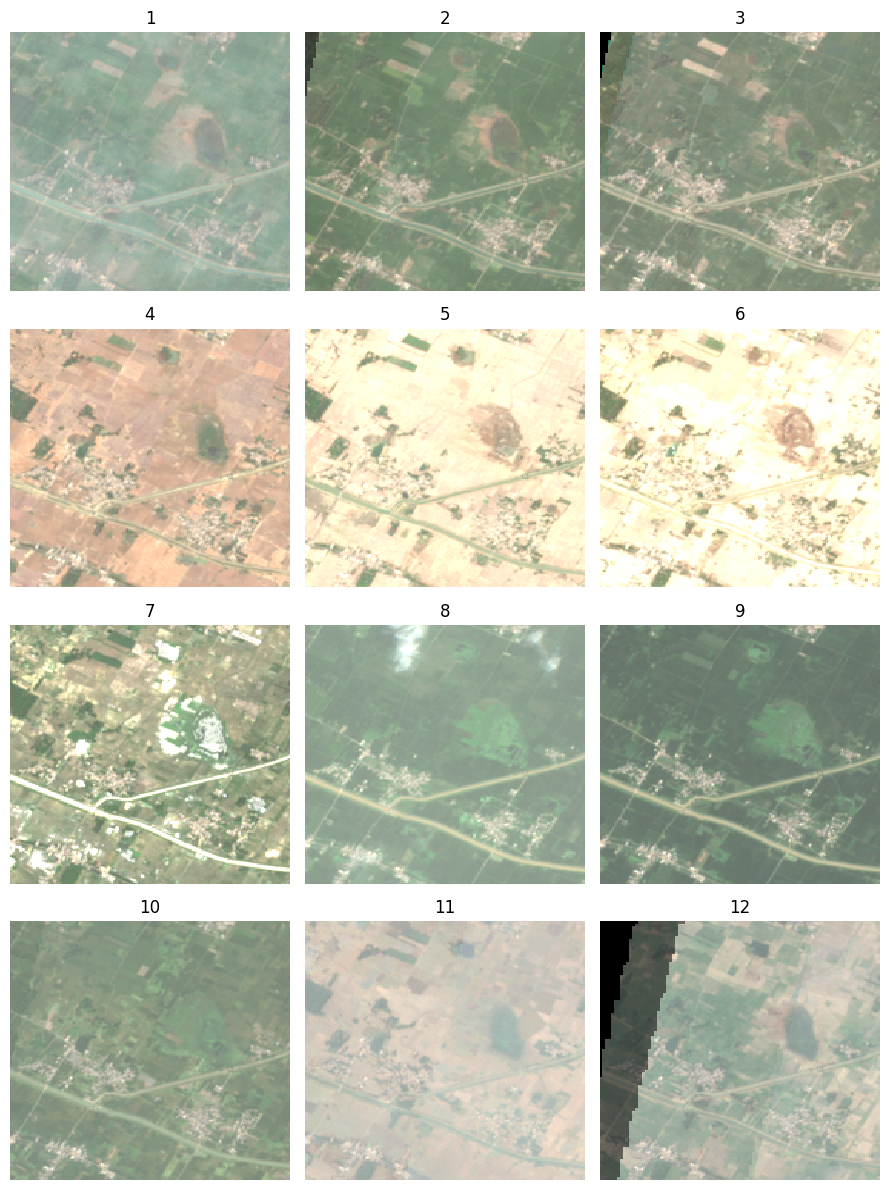

In [ ]:
fig, axes = plt.subplots(4, 3)
fig.set_size_inches(9, 12)
for index, ax in enumerate(axes.flat):
  #enumerate will also track the index of the data
  #The enumerate(axes.flat) construction is used to loop over the flattened axes array while keeping track of the index of each subplot.
    monthly_da = month_da.isel(month=index)
    monthly_da.sel(band=['red', 'green', 'blue']).plot.imshow(
      ax=ax,
      vmin=0,
      vmax=3000)
    ax.set_title(f'{monthly_da.month.values}')
    ax.set_axis_off()
plt.tight_layout()
plt.show()

#Day 9: Mapping Gridded Datasets

##Overview
In this section, we will take the [Gridded Monthly Temperature Anomaly Data](https://data.giss.nasa.gov/gistemp/) from 1880-present from GISTEMP and visualize the temperature anomaly for any year.

Installing cartopy and netcdf

In [4]:
 !pip install cartopy netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.9 MB/s eta 0:00:00


In [5]:
import os
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs

In [6]:
import os
main_path="/content/drive/MyDrive/Jobs_Projects_Doc/Spatial_Analysis_Python"
data_folder="data"
output_folder="output"

data_folder_path=os.path.join(main_path,data_folder)
output_folder_path=os.path.join(main_path,output_folder)

if not os.path.exists(data_folder_path):
  os.mkdir(data_folder_path)

if not os.path.exists(output_folder_path):
  os.mkdir(output_folder_path)

In [7]:
def download(url):
  filename=os.path.join(data_folder_path, os.path.basename(url))
  if not os.path.exists(filename):
    from urllib.request import urlretrieve
    local, _=urlretrieve(url, filename)
    print('Downloaded' +local)


filename='gistemp1200_GHCNv4_ERSSTv5.nc'
data_url = 'https://github.com/spatialthoughts/python-dataviz-web/releases/' \
  'download/gistemp/'
download(data_url + filename)


##Data Pre-Processing
We read the ncdf format data using XArray and select the tempanomaly variable.

In [8]:
file_path = os.path.join(data_folder_path, filename)
#opening netcdf file
ds = xr.open_dataset(file_path)
ds

<xarray.Dataset> Size: 112MB
Dimensions:      (lat: 90, lon: 180, time: 1733, nv: 2)
Coordinates:
  * lat          (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * lon          (lon) float32 720B -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * time         (time) datetime64[ns] 14kB 1880-01-15 1880-02-15 ... 2024-05-15
Dimensions without coordinates: nv
Data variables:
    time_bnds    (time, nv) datetime64[ns] 28kB ...
    tempanomaly  (time, lat, lon) float32 112MB ...
Attributes:
    title:        GISTEMP Surface Temperature Analysis
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    Conventions:  CF-1.6
    history:      Created 2024-06-09 12:46:51 by SBBX_to_nc 2.0 - ILAND=1200,...

In [9]:
da = ds.tempanomaly
da

<xarray.DataArray 'tempanomaly' (time: 1733, lat: 90, lon: 180)> Size: 112MB
[28074600 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 720B -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * time     (time) datetime64[ns] 14kB 1880-01-15 1880-02-15 ... 2024-05-15
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

We have monthly anomalies from 1880-present. Let's aggregate it to mean yealy anomalies.

In [10]:
yearly = da.groupby('time.year').mean(dim='time')
yearly

<xarray.DataArray 'tempanomaly' (year: 145, lat: 90, lon: 180)> Size: 9MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 3.6616666 ,  3.6616666 ,  3.6616666 , ...,  3.6616666 ,
          3.6616666 ,  3.6616666 ],
        [ 3.6616666 ,  3.6616666 ,  3.6616666 , ...,  3.6616666 ,
          3.6616666 ,  3.6616666 ],
        [ 3.6616666 ,  3.6616666 ,  3.6616666 , ...,  3.6616666 ,
          3.6616666 ,  3.6616666 ]],

       [[-0.748     , -0.748     , -0.748     , ..., -0.748     ,
         -0.748     , -0.748     ],
        [-0.748     , -0.748     , -0.748     , ..., -0.748     ,
         -0.748     , -0.748     ],
        [-0.748     , -0.748     , -0.748     , ..., -0.748     ,
         -0.748     , -0.748     ],
        ...,
        [ 4.4999995 ,  4.4999995 ,  4.4999995 , ...,  4.4999995 ,
          4.4999995 ,  4.4999995 ],
        [ 4.4999995 ,  4.4999995 ,  4.4999995 , ...,  4.4999995 ,
          4.4999995 ,  4.4999995 ],
        [ 4.4999995 ,  4.4999995 ,  4.4999995 , ...,  4.4999995 ,
          4.4999995 ,  4.4999995 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 720B -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * year     (year) int64 1kB 1880 1881 1882 1883 1884 ... 2021 2022 2023 2024
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

##Plotting using Matplotlib
Let's extract the data for one of the years.

We can use the .sel() method to query using the value of the year dimension.

In [11]:
year=2023
anomaly=yearly.sel(year=year)
anomaly

<xarray.DataArray 'tempanomaly' (lat: 90, lon: 180)> Size: 65kB
array([[-0.10916665, -0.10916665, -0.10916665, ..., -0.10916665,
        -0.10916665, -0.10916665],
       [-0.10916665, -0.10916665, -0.10916665, ..., -0.10916665,
        -0.10916665, -0.10916665],
       [-0.10916665, -0.10916665, -0.10916665, ..., -0.10916665,
        -0.10916665, -0.10916665],
       ...,
       [ 3.6616666 ,  3.6616666 ,  3.6616666 , ...,  3.6616666 ,
         3.6616666 ,  3.6616666 ],
       [ 3.6616666 ,  3.6616666 ,  3.6616666 , ...,  3.6616666 ,
         3.6616666 ,  3.6616666 ],
       [ 3.6616666 ,  3.6616666 ,  3.6616666 , ...,  3.6616666 ,
         3.6616666 ,  3.6616666 ]], dtype=float32)
Coordinates:
  * lat      (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 720B -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
    year     int64 8B 2023
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

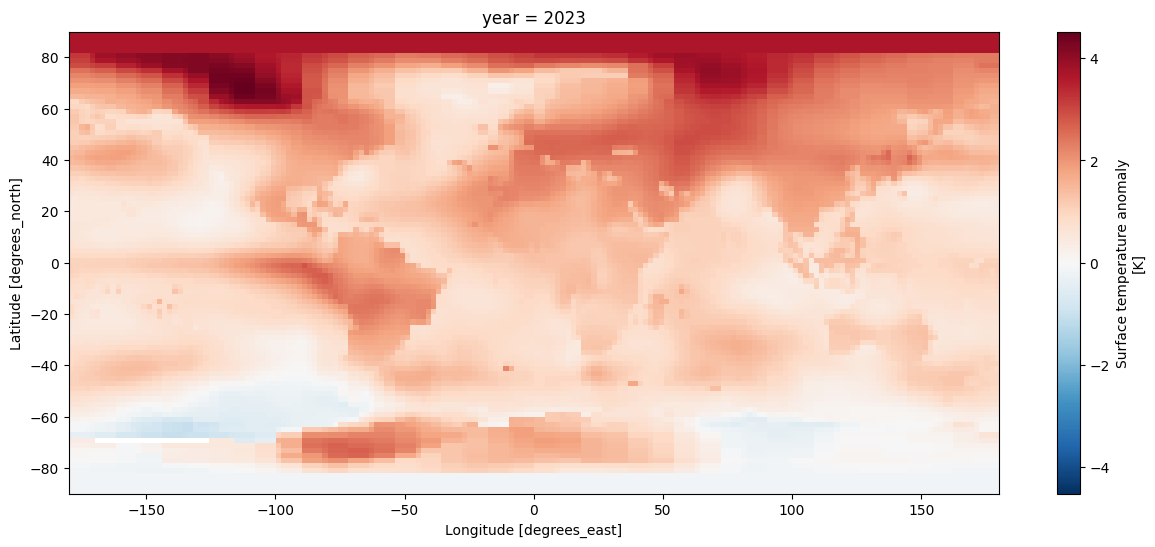

In [12]:
fig,ax=plt.subplots(1,1)
fig.set_size_inches(15,6)
anomaly.plot.imshow(ax=ax)
plt.show()

We can customize the plot using Matplotlib's options. Lets change the legend from (-4,4) to(-3,3)

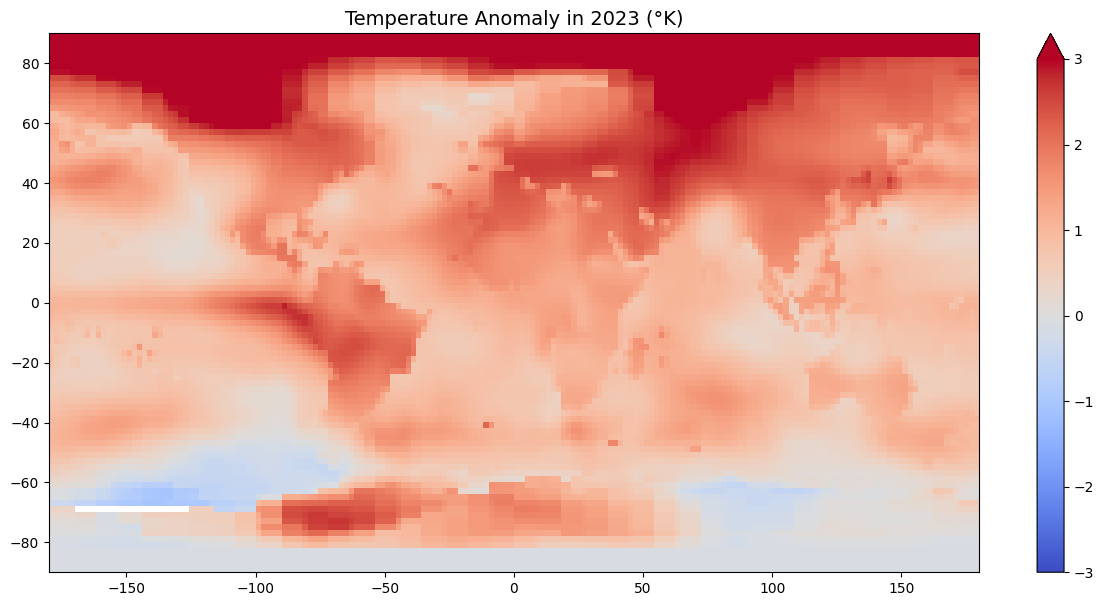

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)

anomaly.plot.imshow(ax=ax,
    vmin=-3, vmax=3, add_labels=False, cmap='coolwarm')

ax.set_title(f'Temperature Anomaly in {year} (°K)', fontsize = 14)

plt.show()

##Plotting using CartoPy
To create more informative map visualization, we need to reproject this grid to another projection. CartoPy supports a wide range of projections and can plot them using matplotlib. CartoPy creates a GeoAxes object and replaces the default Axes with it. This allows you to plot the data on a specified projection.

We start as usual by create a subplot but specify an additional argument to set the CRS from CartoPy.

Reference: [CartoPy List of Projections](https://scitools.org.uk/cartopy/docs/latest/reference/crs.html#list-of-projections)

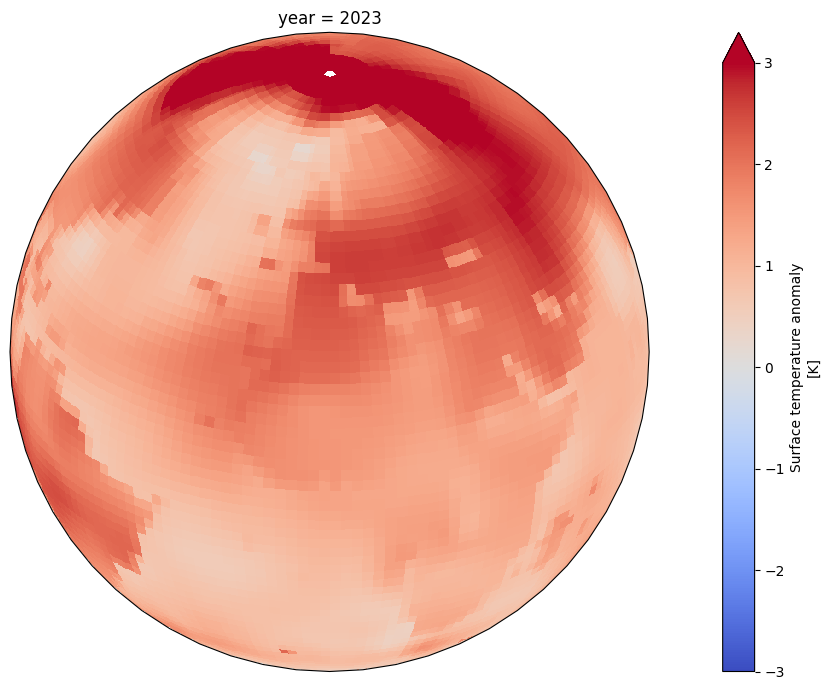

In [13]:
projection=ccrs.Orthographic(0,30)
fig,ax=plt.subplots(1,1,subplot_kw={'projection':projection})
fig.set_size_inches(15,7)
anomaly.plot.imshow(ax=ax, vmin=-3,vmax=3,cmap='coolwarm',
                    transform=ccrs.PlateCarree())
plt.tight_layout()
plt.show()

We can further customize the map by adjusting the colorbar.

Reference: [matplotlib.pyplot.colorbar](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html)

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


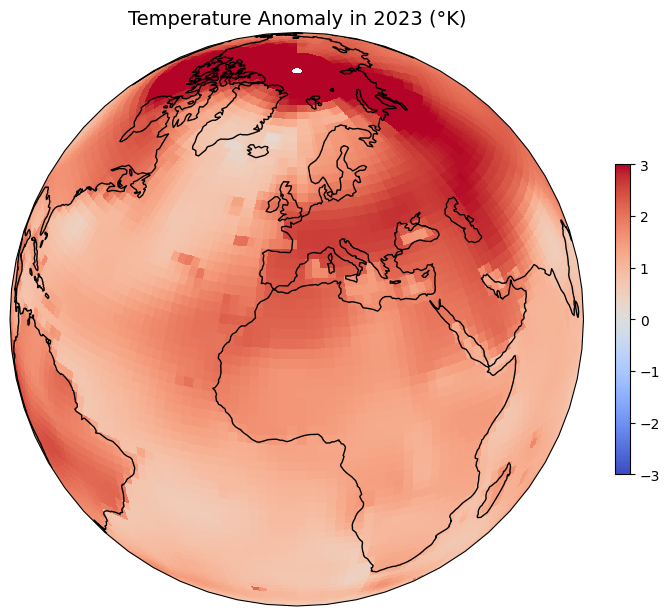

In [14]:
projection = ccrs.Orthographic(0, 30)

cbar_kwargs = {
    'fraction': 0.025,
    'pad': 0.05,
    'extend':'neither'
}

fig, ax = plt.subplots(1, 1, subplot_kw={'projection': projection})
fig.set_size_inches(8, 8)
anomaly.plot.imshow(
    ax=ax,
    vmin=-3, vmax=3, cmap='coolwarm',
    transform=ccrs.PlateCarree(),
    add_labels=False,
    cbar_kwargs=cbar_kwargs)

ax.coastlines()
plt.title(f'Temperature Anomaly in {year} (°K)', fontsize = 14)

output_folder_path = '/content/drive/MyDrive/Jobs_Projects_Doc/Spatial_Analysis_Python/output'
output_path = os.path.join(output_folder_path, 'anomaly.jpg')
#plt.savefig(output_path, dpi=300)
plt.show()

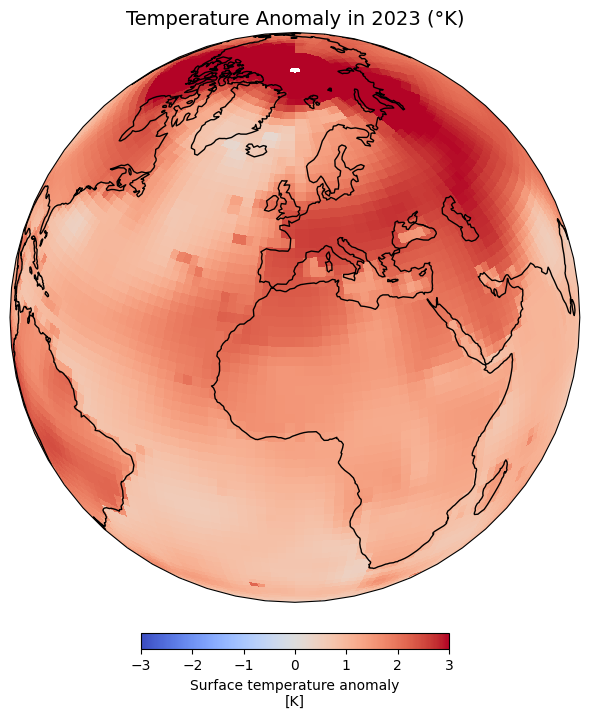

In [15]:
projection = ccrs.Orthographic(0, 30)

cbar_kwargs = {
    'orientation':'horizontal',
    'fraction': 0.025,
    'pad': 0.05,
    'extend':'neither'
}

fig, ax = plt.subplots(1, 1, subplot_kw={'projection': projection})
fig.set_size_inches(8, 8)
anomaly.plot.imshow(
    ax=ax,
    vmin=-3, vmax=3, cmap='coolwarm',
    transform=ccrs.PlateCarree(),
    add_labels=True,
    cbar_kwargs=cbar_kwargs)

ax.coastlines()
plt.title(f'Temperature Anomaly in {year} (°K)', fontsize = 14)

output_folder_path = '/content/drive/MyDrive/Jobs_Projects_Doc/Spatial_Analysis_Python/output'
output_path = os.path.join(output_folder_path, 'anomaly.jpg')
plt.savefig(output_path, dpi=300)
plt.show()

##Exercise
Display the map in the Equal Earth projection.

<img src='https://courses.spatialthoughts.com/images/python_dataviz/anomaly.png' width=400/>

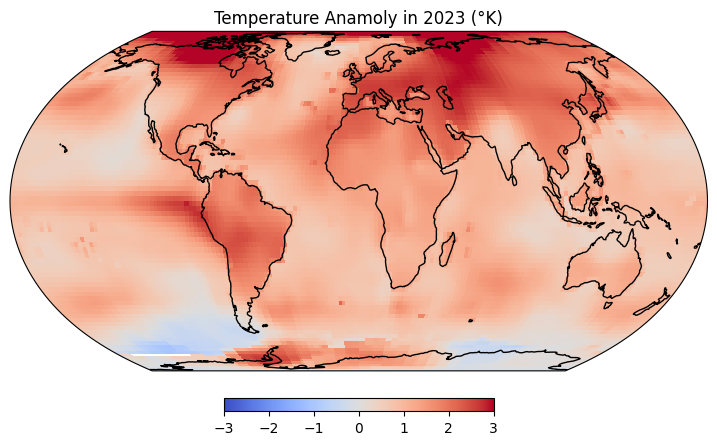

In [27]:
projection=ccrs.EqualEarth(0,30)

cbar_kwargs={
    'orientation':'horizontal',
    'fraction':0.025,
    'pad':0.05,
    'extend':'neither'
}
fig,ax=plt.subplots(1,1,subplot_kw={'projection':projection})
fig.set_size_inches(9,7)
anomaly.plot.imshow(ax=ax,vmin=-3,vmax=3,cmap='coolwarm',transform=ccrs.PlateCarree(),add_labels=False,cbar_kwargs=cbar_kwargs)
ax.coastlines()
ax.set_title('Temperature Anamoly in 2023 (°K)')



output_folder='/content/drive/MyDrive/Jobs_Projects_Doc/Spatial_Analysis_Python/output'
output_path=os.path.join(output_folder,'Temperature_Anamoly_Equal_Earth_projection2023.png')
plt.savefig(output_path, dpi=300)
plt.show()


##Creating Globe Visualization
(Supplement eclipse globe.ipynb)

In [28]:
 !pip install cartopy rioxarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 46.9 MB/s eta 0:00:00


In [29]:
import cartopy
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import requests
import rioxarray as rxr
import shapely
import zipfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
main_path="/content/drive/MyDrive/Jobs_Projects_Doc/Spatial_Analysis_Python"
data_folder="data"
output_folder="output"

data_folder_path=os.path.join(main_path,data_folder)
output_folder_path=os.path.join(main_path,output_folder)

if not os.path.exists(data_folder_path):
  os.mkdir(data_folder_path)

if not os.path.exists(output_folder_path):
  os.mkdir(output_folder_path)

In [30]:
def download(url):
    filename = os.path.join(data_folder_path, os.path.basename(url))
    if not os.path.exists(filename):
      with requests.get(url, stream=True, allow_redirects=True) as r:
          with open(filename, 'wb') as f:
              for chunk in r.iter_content(chunk_size=8192):
                  f.write(chunk)
      print('Downloaded', filename)

In [31]:
# Get the eclipse shapefiles
path_shapefile = 'upath17'
umbra_shapefile = 'umbra17'
penumbra_shapefile = 'penum17'

shapefile_exts = ['.shp', '.shx', '.dbf', '.prj']
data_url = 'https://github.com/spatialthoughts/python-dataviz-web/releases/' \
  'download/eclipse/'

for shapefile in [path_shapefile, umbra_shapefile, penumbra_shapefile]:
  for ext in shapefile_exts:
    url = data_url + shapefile + ext
    download(url)

# Get the Blue Marble basemap image
data_url = 'https://github.com/spatialthoughts/python-dataviz-web/releases/' \
  'download/bluemarble/'
basemap_file = 'eo_base_2020_clean_geo_resampled.tif'
download(data_url + basemap_file)

##Data Pre-Processing

In [32]:
path_shapefile_path = os.path.join(
    data_folder_path, path_shapefile + '.shp')
umbra_shapefile_path = os.path.join(
    data_folder_path, umbra_shapefile + '.shp')
penumbra_shapefile_path = os.path.join(
    data_folder_path, penumbra_shapefile + '.shp')

path_gdf = gpd.read_file(path_shapefile_path)
umbra_gdf = gpd.read_file(umbra_shapefile_path)
penumbra_gdf = gpd.read_file(penumbra_shapefile_path)

Choose a Orthographic Projection centered on the continental USA. Convert the CartoPy projection to a GeoPandas projection and reproject the data layers.

In [33]:
cartopy_crs = ccrs.Orthographic(-100, 45)
crs= cartopy_crs.proj4_init  #Retrieves projection in string format

# Reproject using GeoPandas
# CartoPy reprojection on-the-fly while plotting results in artifacts
penumbra_gdf_reprojected = penumbra_gdf.to_crs(crs)
umbra_gdf_reprojected = umbra_gdf.to_crs(crs)
path_gdf_reprojected = path_gdf.to_crs(crs)

Read the Blue Marble basemap image

In [36]:
basemapth_path = os.path.join(data_folder_path, basemap_file)
basemap_ds = rxr.open_rasterio(basemapth_path)
basemap_ds

<xarray.DataArray (band: 3, y: 3600, x: 7200)> Size: 78MB
[77760000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 58kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * y            (y) float64 29kB 89.97 89.92 89.88 ... -89.88 -89.93 -89.98
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:        Adobe Photoshop 21.1 (Macintosh)
    TIFFTAG_DATETIME:        2020:08:27 15:53:52
    TIFFTAG_XRESOLUTION:     72
    TIFFTAG_YRESOLUTION:     72
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0

##Create a Globe Visualization

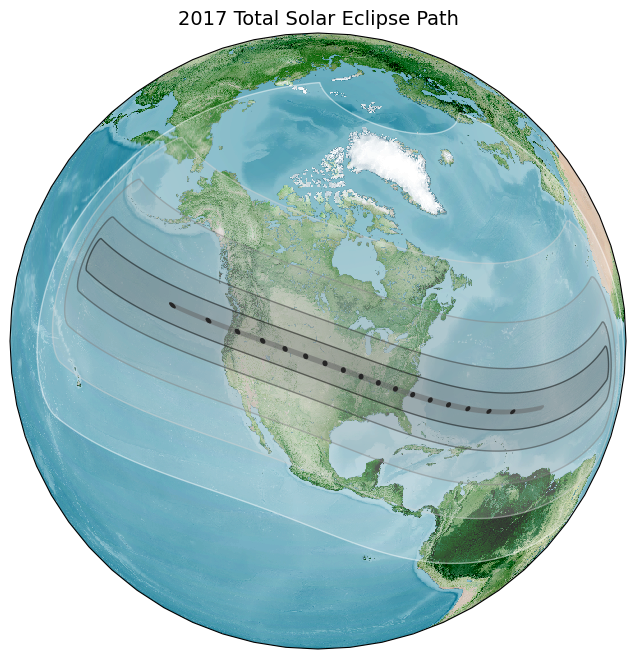

In [37]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': cartopy_crs})
fig.set_size_inches(8, 8)

# Plot the basemap
basemap_ds.plot.imshow(
    ax=ax,
    transform=ccrs.PlateCarree(),
    robust=True)

# Plot the DataFrames

# Plot penumbra shadows with just fills
penumbra_gdf_reprojected.plot(
    ax=ax,
    column='Obscur',
    cmap='Greys',
    edgecolor='none',
    alpha=0.2
)

# Plot penumbra shadows with outlines
penumbra_gdf_reprojected.plot(
    ax=ax,
    column='Obscur',
    cmap='Greys',
    linewidth=1,
    facecolor='none',
    alpha=0.5
)

path_gdf_reprojected.to_crs(crs).plot(
    ax=ax,
    facecolor='#636363',
    edgecolor='none',
    alpha=0.5,
)

umbra_gdf_reprojected.to_crs(crs).plot(
    ax=ax,
    facecolor='#252525',
    edgecolor='none')


plt.title('2017 Total Solar Eclipse Path', fontsize=14)

plt.show()

#Day 10: Visualizing Rasters

## Overview

In the previous notebook, we learnt how to use [Xarray](http://xarray.pydata.org/) to work with gridded datasets. XArray is also well suited to work with georeferenced rasters - such as satellite imagery, population grids, or elevation data.[rioxarray](https://corteva.github.io/rioxarray/stable/index.html) is an extension of xarray that makes it easy to work with geospatial rasters.

In this section, we will take 4 individual SRTM tiles around the Mt. Everest region and merge them to a single GeoTiff using RasterIO. We will also use `matplotlib` to add labels to the final map using annonations.

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [38]:
!pip install rioxarray

By convention, `rioxarray` is imported as `rxr`.

> Remember to always import `rioxarray` even if you are using sub-modules such as `merge_arrays`. Importing `rioxarray` activates the `rio` accessor which is required for all operations.

In [39]:
import os
import rioxarray as rxr
from rioxarray.merge import merge_arrays
import matplotlib.pyplot as plt

In [42]:
def download(url):
    filename = os.path.join(data_folder_path, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

In [43]:
srtm_tiles = [
  'N27E086.hgt',
  'N27E087.hgt',
  'N28E086.hgt',
  'N28E087.hgt'
]

data_url = 'https://github.com/spatialthoughts/python-dataviz-web/releases/' \
  'download/srtm/'

for tile in srtm_tiles:
  url = '{}/{}'.format(data_url, tile)
  download(url)

Downloaded /content/drive/MyDrive/Jobs_Projects_Doc/Spatial_Analysis_Python/data/N27E086.hgt
Downloaded /content/drive/MyDrive/Jobs_Projects_Doc/Spatial_Analysis_Python/data/N27E087.hgt
Downloaded /content/drive/MyDrive/Jobs_Projects_Doc/Spatial_Analysis_Python/data/N28E086.hgt
Downloaded /content/drive/MyDrive/Jobs_Projects_Doc/Spatial_Analysis_Python/data/N28E087.hgt


##Rioxarray Basics
The `open_rasterio()` method from `rioxarray` is able to read any data source supported by. the [`rasterio`](https://rasterio.readthedocs.io/en/latest/) library. Let's open a single SRTM tile using `rioxarray`.

The result is a xarray.DataArray object.

In [44]:
#Lets read 'N28E087.hgt' file
file='N28E087.hgt'
filepath=os.path.join(data_folder_path,file)
ds=rxr.open_rasterio(filepath)
ds   #xarray.dataArray object

<xarray.DataArray (band: 1, y: 3601, x: 3601)> Size: 26MB
[12967201 values with dtype=int16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 29kB 87.0 87.0 87.0 87.0 ... 88.0 88.0 88.0 88.0
  * y            (y) float64 29kB 29.0 29.0 29.0 29.0 ... 28.0 28.0 28.0 28.0
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    _FillValue:     -32768
    scale_factor:   1.0
    add_offset:     0.0
    units:          m

Pixel values can be accessed using the values property which returns the array’s data as a numpy array.

In [46]:
ds.values

array([[[5217, 5211, 5208, ..., 5097, 5098, 5089],
        [5206, 5201, 5200, ..., 5080, 5075, 5069],
        [5199, 5194, 5191, ..., 5063, 5055, 5048],
        ...,
        [5347, 5345, 5343, ..., 5747, 5750, 5757],
        [5338, 5338, 5336, ..., 5737, 5740, 5747],
        [5332, 5331, 5332, ..., 5734, 5736, 5744]]], dtype=int16)

A `xarray.DataArray` object also contains 1 or more `coordinates`. Each coordinate is a 1-dimensional array representing values along one of the data axes. In case of the 1-band SRTM elevation data, we have 3 coordinates - `x`, `y` and `band`.

In [47]:
ds.coords

Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 29kB 87.0 87.0 87.0 87.0 ... 88.0 88.0 88.0 88.0
  * y            (y) float64 29kB 29.0 29.0 29.0 29.0 ... 28.0 28.0 28.0 28.0
    spatial_ref  int64 8B 0

The raster metadata is stored in the [`rio`](https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray-rio-accessors) accessor. This is enabled by the `rioxarray` library which provides geospatial functions on top of `xarray`.

In [48]:
print('CRS:',ds.rio.crs)
print('Resolution:', ds.rio.resolution())
print('Bounds:',ds.rio.bounds())
print('Width:',ds.rio.width)
print('Height:',ds.rio.height)

CRS: EPSG:4326
Resolution: (0.0002777777777777778, -0.0002777777777777778)
Bounds: (86.99986111111112, 27.999861111111112, 88.00013888888888, 29.000138888888888)
Width: 3601
Height: 3601


In [49]:
#Selecting the band
band1=ds.sel(band=1)
band1

<xarray.DataArray (y: 3601, x: 3601)> Size: 26MB
array([[5217, 5211, 5208, ..., 5097, 5098, 5089],
       [5206, 5201, 5200, ..., 5080, 5075, 5069],
       [5199, 5194, 5191, ..., 5063, 5055, 5048],
       ...,
       [5347, 5345, 5343, ..., 5747, 5750, 5757],
       [5338, 5338, 5336, ..., 5737, 5740, 5747],
       [5332, 5331, 5332, ..., 5734, 5736, 5744]], dtype=int16)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 29kB 87.0 87.0 87.0 87.0 ... 88.0 88.0 88.0 88.0
  * y            (y) float64 29kB 29.0 29.0 29.0 29.0 ... 28.0 28.0 28.0 28.0
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    _FillValue:     -32768
    scale_factor:   1.0
    add_offset:     0.0
    units:          m

##Plotting multiple rasters in the same plot
Open each source file using `open_rasterio()` method and store the resulting datasets in a list.

In [50]:
datasets=[]
for file in srtm_tiles:
  filepath = os.path.join(data_folder_path,file)
  data = rxr.open_rasterio(filepath)
  band = data.sel(band=1)
  datasets.append(band)



In [51]:
datasets

[<xarray.DataArray (y: 3601, x: 3601)> Size: 26MB
 [12967201 values with dtype=int16]
 Coordinates:
     band         int64 8B 1
   * x            (x) float64 29kB 86.0 86.0 86.0 86.0 ... 87.0 87.0 87.0 87.0
   * y            (y) float64 29kB 28.0 28.0 28.0 28.0 ... 27.0 27.0 27.0 27.0
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Point
     _FillValue:     -32768
     scale_factor:   1.0
     add_offset:     0.0
     units:          m,
 <xarray.DataArray (y: 3601, x: 3601)> Size: 26MB
 [12967201 values with dtype=int16]
 Coordinates:
     band         int64 8B 1
   * x            (x) float64 29kB 87.0 87.0 87.0 87.0 ... 88.0 88.0 88.0 88.0
   * y            (y) float64 29kB 28.0 28.0 28.0 28.0 ... 27.0 27.0 27.0 27.0
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Point
     _FillValue:     -32768
     scale_factor:   1.0
     add_offset:     0.0
     units:          m,
 <xarray.DataArray (y: 3601, x: 3601)> Size: 26MB
 [12967201 values with dtype=int16

You can visualize any `DataArray` object by calling `plot()` method. Here we create a subplot with 1 row and 4 columns. The `subplots()` method will return a list of Axes that we can use to render each of the source SRTM rasters. For plots with multiple columns, the Axes will be a nested list. To easily iterate over it, we can use `.flat` which returns a 1D iterator on the axes.

While plotting the data, we can use the `cmap` option to specify a color ramp. Here we are using the built-in *Greys* ramp. Appending **_r** gives us the inverted ramp with blacks representing lower elevation values. When plotting on multiple Axes, it is useful to specify `set_aspect('equal')` so the aspect raio of the plot is maintained even if there is not enough space.

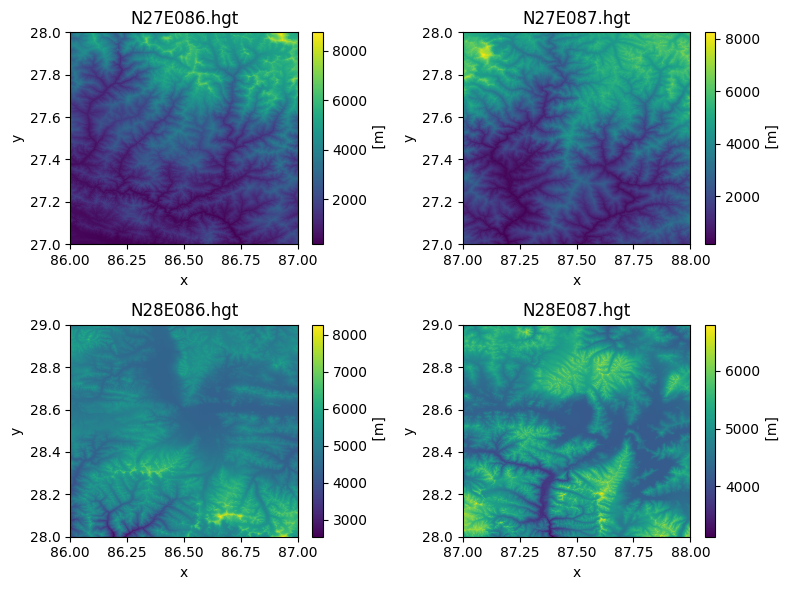

In [62]:
fig,axes=plt.subplots(2,2)
fig.set_size_inches(8,6)
for index,ax in enumerate(axes.flat):
  df=datasets[index]
  df.plot.imshow(ax=ax)
  filename=srtm_tiles[index]
  ax.set_title(filename)

plt.tight_layout()
plt.show()

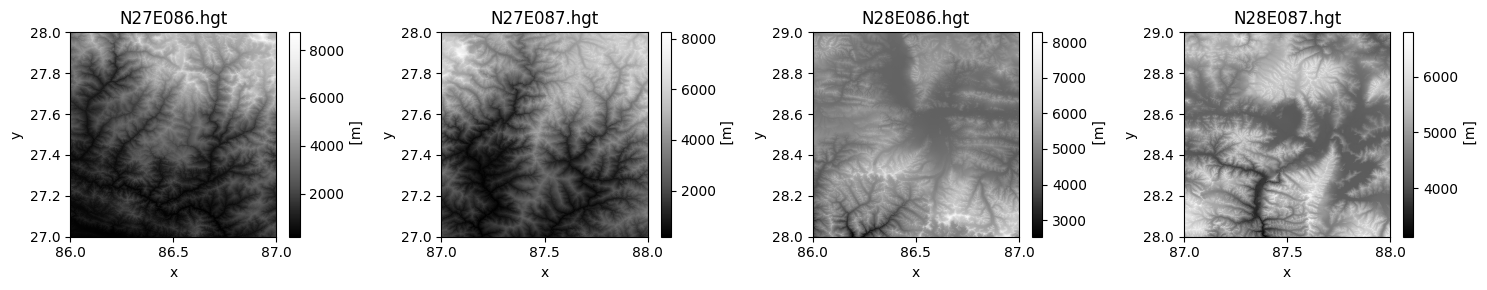

In [63]:
fig,axes=plt.subplots(1,4)
fig.set_size_inches(15,3)
for index,ax in enumerate(axes.flat):
  df=datasets[index]
  df.plot.imshow(ax=ax,cmap='Greys_r')
  filename=srtm_tiles[index]
  ax.set_title(filename)

plt.tight_layout()
plt.show()

##Merging Rasters
Now that you understand the basic data structure of *xarray* and the *rio* extension, let's use it to process some data. We will take 4 individual SRTM tiles and merge them to a single GeoTiff. You will note that `rioxarray` handles the CRS and transform much better - taking care of internal details and providing a simple API.

We will use the `merge_arrays()` method from the `rioxarray.merge` module to merge the rasters. We can also specify an optional `method` that controls how overlapping tiles are merged. Here we have chosen `first` which takes the value of the first raster in the overlapping region.

Reference: [`merge_arrays()`](https://corteva.github.io/rioxarray/html/rioxarray.html#rioxarray.merge.merge_arrays)

In [66]:
merged_data=merge_arrays(datasets,method='first') #This datsets has no overlaps. If there are overlaps then we should consider either min, max methods
merged_data

<xarray.DataArray (y: 7201, x: 7201)> Size: 104MB
array([[4916, 4926, 4931, ..., 5097, 5098, 5089],
       [4919, 4932, 4928, ..., 5080, 5075, 5069],
       [4919, 4928, 4935, ..., 5063, 5055, 5048],
       ...,
       [ 368,  368,  366, ..., 1905, 1919, 1937],
       [ 364,  364,  362, ..., 1913, 1930, 1944],
       [ 360,  359,  357, ..., 1918, 1930, 1942]], dtype=int16)
Coordinates:
  * x            (x) float64 58kB 86.0 86.0 86.0 86.0 ... 88.0 88.0 88.0 88.0
  * y            (y) float64 58kB 29.0 29.0 29.0 29.0 ... 27.0 27.0 27.0 27.0
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    _FillValue:     -32768
    scale_factor:   1.0
    add_offset:     0.0
    units:          m

We can now visualize the merged raster.

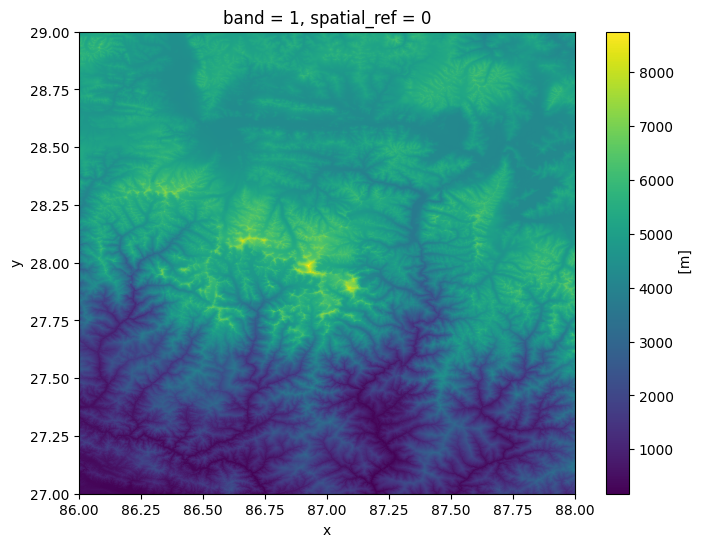

In [67]:
fig,ax=plt.subplots(1,1)
fig.set_size_inches(8,6)
merged_data.plot.imshow(ax=ax)
ax.set_tile('Merged SRTM tiles')
plt.show()

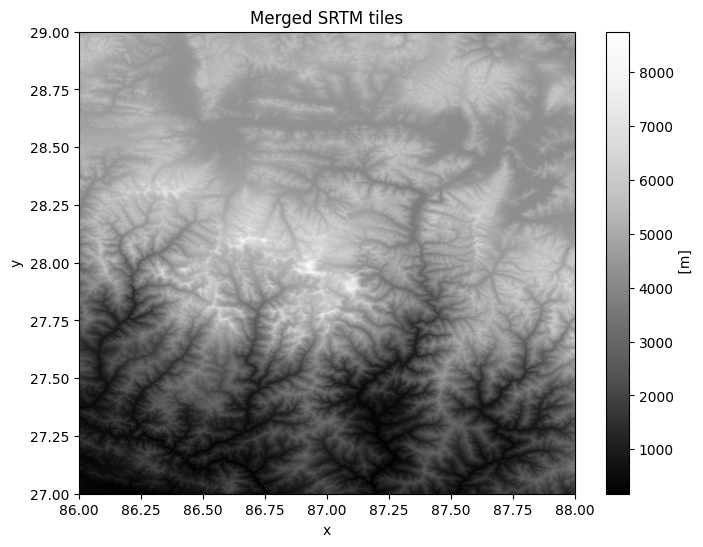

In [101]:
fig,ax=plt.subplots(1,1)
fig.set_size_inches(8,6)
merged_data.plot.imshow(ax=ax,cmap='Greys_r')
ax.set_title('Merged SRTM tiles')
plt.show()

##Save the image in tif format
We can save the resulting raster in any format supported by GDAL using the `to_raster()` method. Let's save this as a [Cloud-Optimized GeoTIFF (COG)](https://gdal.org/drivers/raster/cog.html).

'rio.to_raster'

In [70]:
output_file='Merged_SRTM.tif'
output_path=os.path.join(output_folder_path,output_file)
merged_data.rio.to_raster(output_path,driver='COG')

## Annotating Plots
Sometime it is helpful to add annotations on your plot to highlight a feature or add a text label. In this section we will learn how to use the annotate the DEM to show the location and elevation of Mt. Everest.

First, we locate the coordinates of the maximum elevation in the `merged` DataArray using the `max()` function. We can then use `where()` function to filter the elements where the value equals the maximum elevation. Lastly, we run `squeeze()` to remove the extra empty dimension from the result.

References:

* [xarray.DataArray.max](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.max.html)
* [xarray.DataArray.where](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.where.html)

In [74]:
#Lets see where the max value is present in merged_data
max_da=merged_data.where(merged_data==merged_data.max())
max_da  #Return values only for max pixels and the remaining pixels will have nan values

<xarray.DataArray (y: 7201, x: 7201)> Size: 207MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float64 58kB 86.0 86.0 86.0 86.0 ... 88.0 88.0 88.0 88.0
  * y            (y) float64 58kB 29.0 29.0 29.0 29.0 ... 27.0 27.0 27.0 27.0
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    _FillValue:     -32768
    scale_factor:   1.0
    add_offset:     0.0
    units:          m

In [75]:
max_da=merged_data.where(merged_data==merged_data.max(),drop=True)
max_da  #Retruns max value in merged data ie., 8748 MountEverest
#coordinates will give the x,y values of the max pixel,
#The extra [] in array([[8748.]], dtype=float32) can be removed using sqeeze()

<xarray.DataArray (y: 1, x: 1)> Size: 4B
array([[8748.]], dtype=float32)
Coordinates:
  * x            (x) float64 8B 86.93
  * y            (y) float64 8B 27.99
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    _FillValue:     -32768
    scale_factor:   1.0
    add_offset:     0.0
    units:          m

In [76]:
max_da=merged_data.where(merged_data==merged_data.max(),drop=True).squeeze()
max_da

<xarray.DataArray ()> Size: 4B
array(8748., dtype=float32)
Coordinates:
    x            float64 8B 86.93
    y            float64 8B 27.99
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    _FillValue:     -32768
    scale_factor:   1.0
    add_offset:     0.0
    units:          m

In [77]:
#To get vaue:
max_da=merged_data.where(merged_data==merged_data.max(),drop=True).squeeze().values
max_da

array(8748., dtype=float32)

We now extract the x,y coordinates and the value of the maximum elevation.

In [80]:
max_da=merged_data.where(merged_data==merged_data.max(),drop=True).squeeze()
max_elevation=int(max_da.values)
max_x=max_da.x.values
max_y=max_da.y.values

print(f'Max elevation value is {max_elevation}')
print(f'X position of Max elevation value is {max_x:.2f}')
print(f'Y position of Max elevation value is {max_y}')

Max elevation value is 8748
X position of Max elevation value is 86.93
Y position of Max elevation value is 27.988888888888887


Now we plot the `merged` raster and annotate it using the `annotate()` function.

Reference: [matplotlib.pyplot.annotate
](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html)

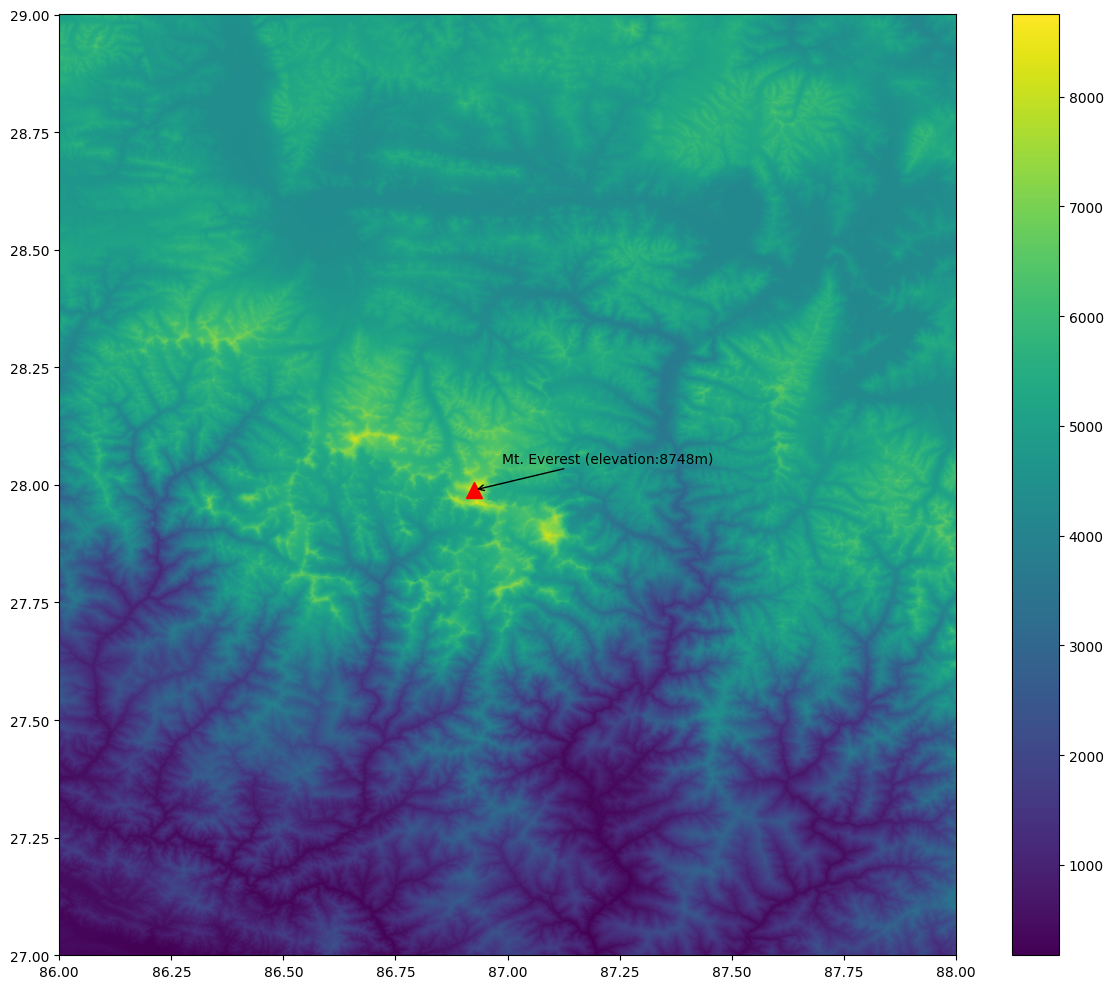

In [85]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 10)
merged_data.plot.imshow(ax=ax, cmap='viridis', add_labels=False)
ax.plot(max_x, max_y, '^r', markersize=11) #Adding red marker
#Annotate will add text and arrow
ax.annotate('Mt. Everest (elevation:{}m)'.format(max_elevation),
            xy=(max_x, max_y), xycoords='data',
            xytext=(20, 20), textcoords='offset points',
            arrowprops={'arrowstyle':'->', 'color':'black'}
            )
plt.tight_layout()
plt.show()

##Exercise
Add contours to the elevation plot below.

<img src='https://courses.spatialthoughts.com/images/python_dataviz/contours.png' width=600/>


Start with the code snippet below and use the [`xarray.plot.contour`](https://docs.xarray.dev/en/stable/generated/xarray.plot.contour.html) function to render the contours

Hint: Use the options `colors=white` and `levels=10`.

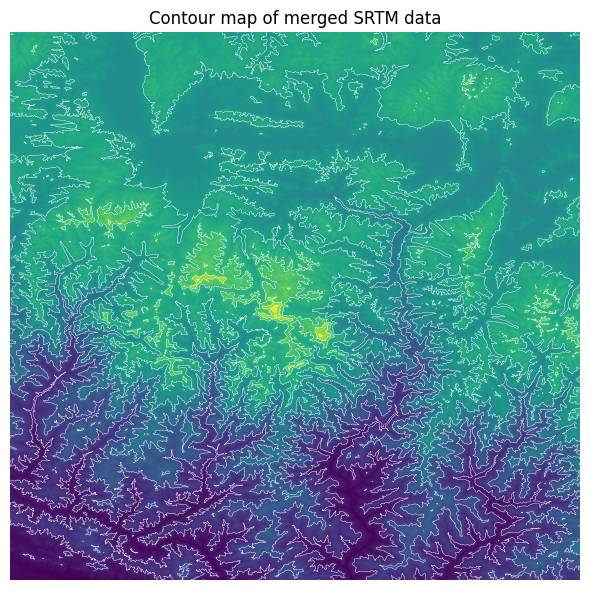

In [105]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 6)
merged_data.plot.imshow(ax=ax, cmap='viridis', add_labels=False, add_colorbar=False)
# Add contours
merged_data.plot.contour(ax=ax, levels=10, colors='white', linewidths=0.3) #levels=10 indicates it drws contours at 10 different automatically choosen levels.
ax.set_title('Contour map of merged SRTM data')
ax.set_axis_off() #Removes X, Y labels
plt.tight_layout()
plt.show()

In [109]:
#Finding level of contour:
import numpy as np
min_value = merged_data.min().item()
max_value = merged_data.max().item()
print(f"Min value: {min_value}, Max value: {max_value}")
num_levels = 10  # Specify the number of levels you want
levels = np.linspace(min_value, max_value, num_levels)
print("Contour Levels:", levels)

Min value: 176, Max value: 8748
Contour Levels: [ 176.         1128.44444444 2080.88888889 3033.33333333 3985.77777778
 4938.22222222 5890.66666667 6843.11111111 7795.55555556 8748.        ]


#ASSIGNMENT
Creating colorised river map of India